In [7]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as models

# Load the modified DeepLabV3 model with 1 output channel
model = models.deeplabv3_resnet50(pretrained=False)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Adjust output channels to 1 for binary segmentation

# Load the model weights
model_path = 'best_model.pth'  # Replace with your actual path to the .pth file

# Load the state dict while ignoring unexpected keys (like auxiliary classifier weights)
state_dict = torch.load(model_path)

# Remove the unwanted keys (auxiliary classifier layers) from the state_dict
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('aux_classifier')}

# Load the state_dict into the model
model.load_state_dict(state_dict, strict=False)

# Ensure the model is on the correct device (CPU in your case)
device = torch.device("cpu")
model = model.to(device)

# Now you can use the model for inference or further training


C:\Users\akhil\AppData\Local\Temp\ipykernel_26984\388705196.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [8]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models.segmentation as models
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = SegmentationDataset("Kvasir-SEG/images", "Kvasir-SEG/masks", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

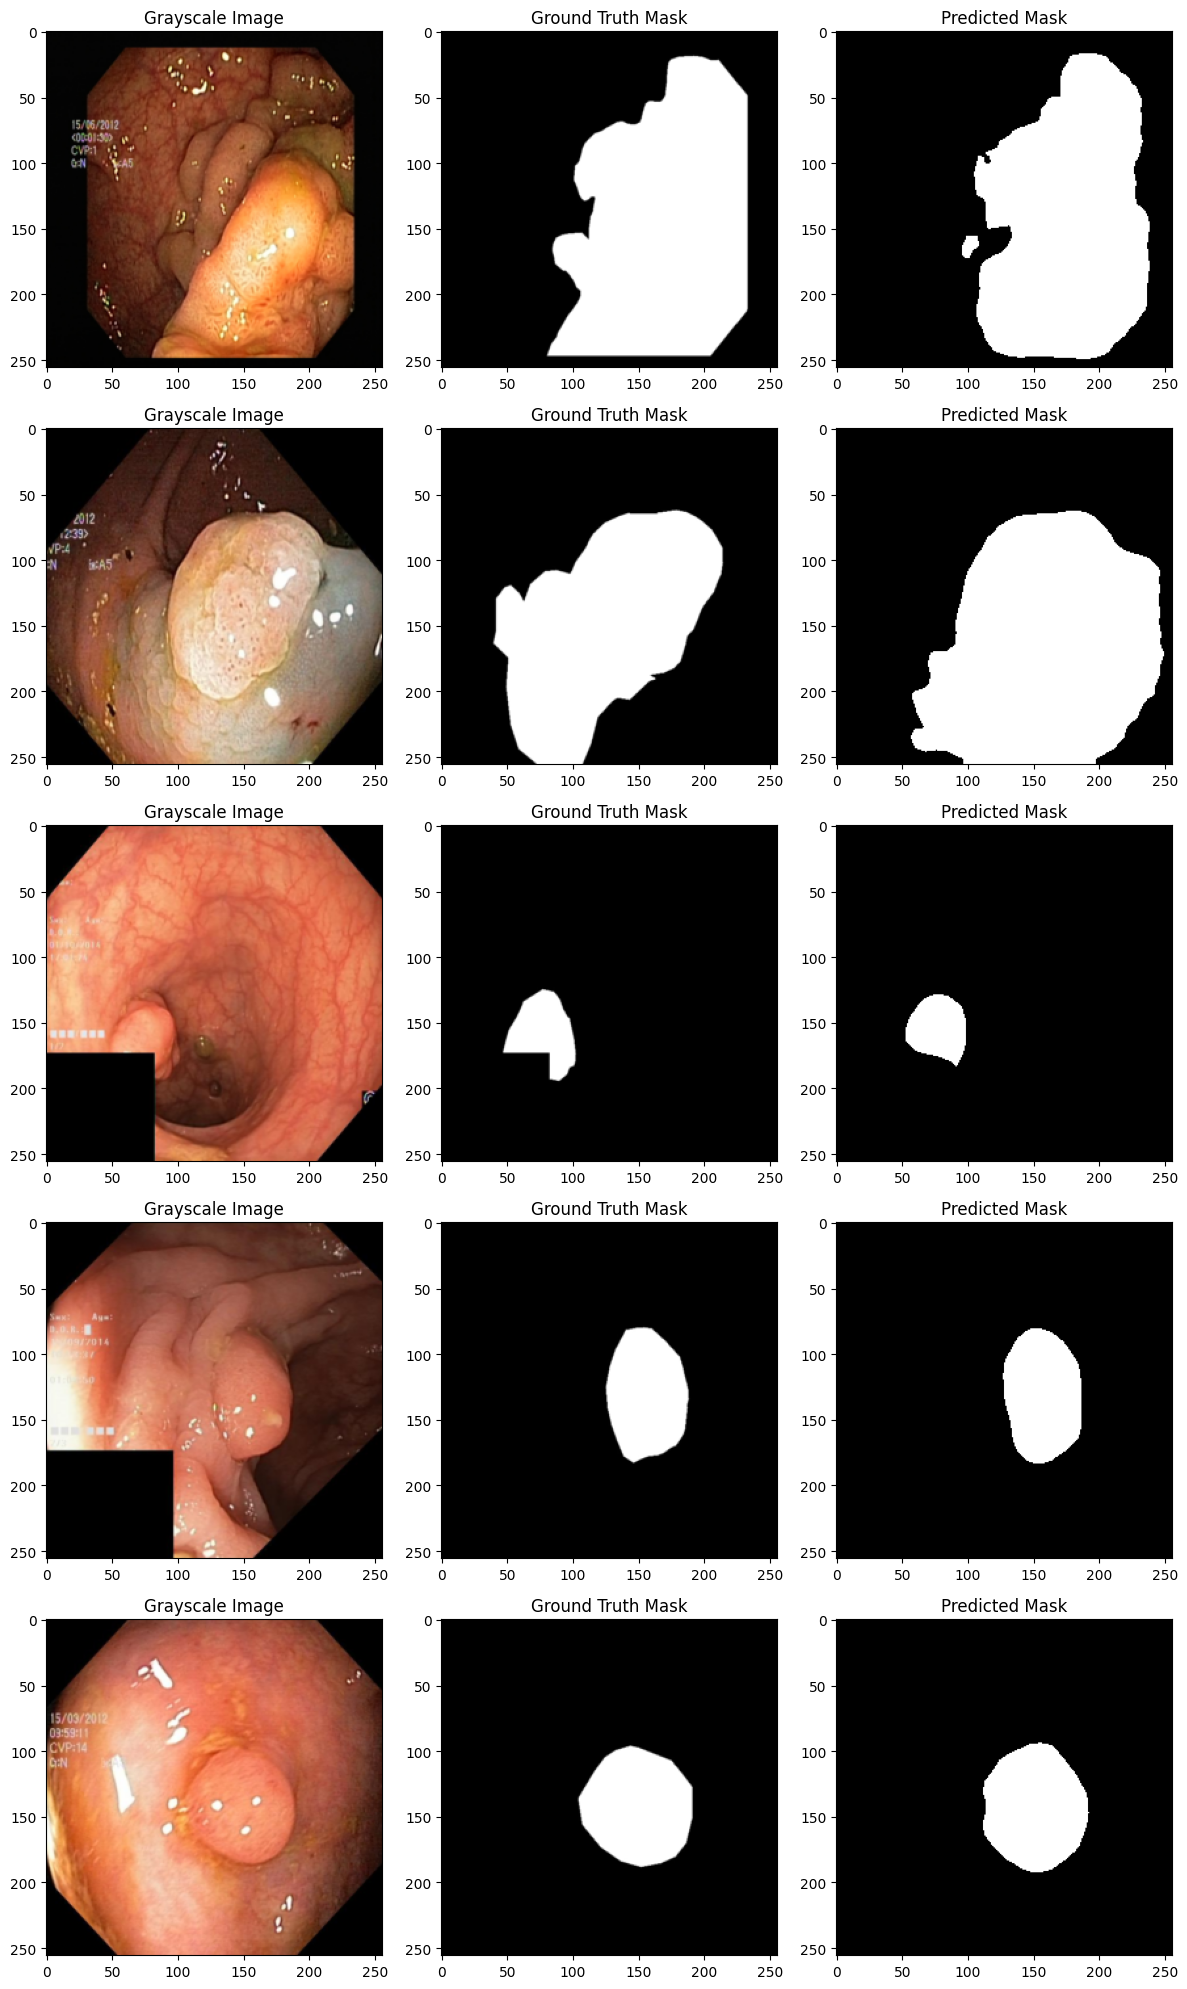

In [11]:
import torch
import matplotlib.pyplot as plt

def plot_sample(image, mask, pred, ax):
    # Convert mask and pred to binary (0 or 1)
    mask = mask.squeeze().cpu().numpy()
    pred = (torch.sigmoid(pred) > 0.5).squeeze().cpu().numpy()

    # Plot the grayscale image
    ax[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Grayscale Image")
    
    # Plot the ground truth mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    
    # Plot the predicted mask
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title("Predicted Mask")

def visualize_performance(model, dataloader, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    
    # Get some random samples from the dataloader
    data_iter = iter(dataloader)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    
    for i in range(num_samples):
        # Get one batch of data
        images, masks = next(data_iter)
        # No need to move to GPU if using CPU
        # images, masks = images.cuda(), masks.cuda()  # Not needed for CPU
        
        # Make predictions
        with torch.no_grad():
            preds = model(images)['out']
        
        # Plot the results
        plot_sample(images[0], masks[0], preds[0], axes[i])
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize the performance
visualize_performance(model, train_loader, num_samples=5)


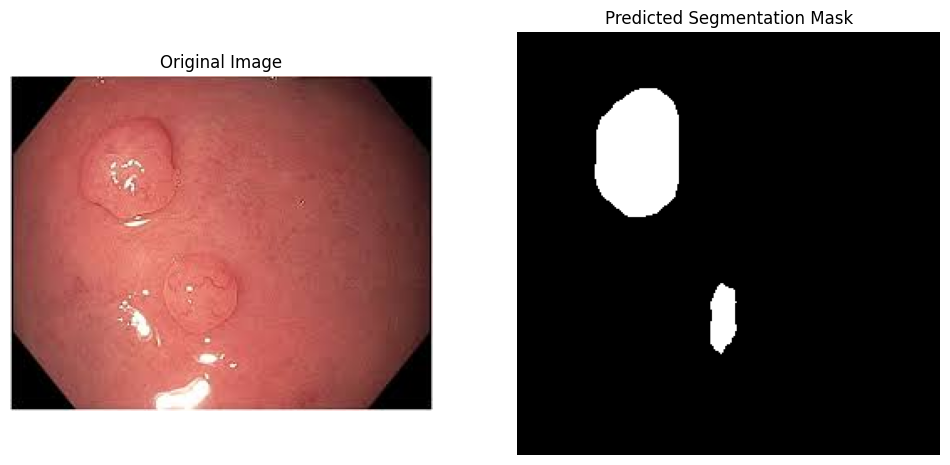

In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the same size as training data
    transforms.ToTensor()           # Convert to tensor
])

# Load the unseen image
image_path = 'test4.jpeg'  # Update with your image path
image = Image.open(image_path).convert("RGB")  # Ensure the image is RGB

# Apply the preprocessing to the image
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Send image to CPU (as model is on CPU)
input_image = input_image.to(torch.device("cpu"))

# Perform inference
with torch.no_grad():  # No gradients required for inference
    output = model(input_image)
    output = output['out']  # Get the output of the segmentation model

# Post-process the output
# - Apply sigmoid to get probabilities (since it's binary segmentation)
output = torch.sigmoid(output)

# Convert the output to a binary mask (0 or 1)
binary_mask = (output.squeeze().cpu().numpy() > 0.7).astype(np.uint8)  # Apply threshold

# Display the original image and the segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Show original image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Show segmentation mask
ax[1].imshow(binary_mask, cmap='gray')
ax[1].set_title("Predicted Segmentation Mask")
ax[1].axis('off')

plt.show()